# Introduction

Following the order of cell in this notebook, you can finish the testing processing easily.

## 1 Setup environments

### 1.1. Import Python dependencies and Setup GPU.

Here, we use GPU 0 in default. If you have multiple GPUs, please specific the <ID\> of GPU you want to use for testing as following:

```python
os.environ["CUDA_VISIBLE_DEVICES"] = "<ID>"
```

In [1]:
# import common used libs
import os
import glob

# use single GPU, please specify the GPU ID if have multiple GPUs
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# cv libs
import cv2
import numpy as np

# deep learning libs
import torch
from torch.utils.data import DataLoader, Dataset
from efficientnet_pytorch import model as enet

import albumentations as A
from albumentations.pytorch import ToTensorV2

# for better visualization
from tqdm.notebook import tqdm
%matplotlib inline
import matplotlib.pyplot as plt

### 1.2. Setup paths and hyperparameters.

In this cell, we setup the test data path, which is orgnized as same as ImageNet data.

Modity the <TEST_ROOT> to the real test data directory:
```python
TEST_ROOT = <real_test_root>
```

Modity the <TEST_OUTPUT_CSV> to the path you want the result save to:
```python
TEST_OUTPUT_CSV = <real_output_path>
```

Note: you can reduce <BATCH_SIZE> and <NUM_WORKERS> if GPU memory or CPU is not enough. This do not influence the test result.

In [2]:
# path to test image root
TEST_ROOT = './data/val'

# path to output .csv file
TEST_OUTPUT_CSV = './output/test.csv'

# resize image longest side to <BASE_SIZE>
BASE_SIZE = 640

# hyperparameters for dataloader
# reduce <BATCH_SIZE> and <NUM_WORKERS> if GPU memory or CPU is not enough. Do not influence test result
BATCH_SIZE = 16
NUM_WORKERS = 16 # number of processes 

# Image classification backbone
BACKBONE = 'efficientnet-b6'

# trained model checkpoint
CHECKPOINT_PATH = "./checkpoints/final.pth"

# predefined class names as same as train notebook.
CLASSES = ["sneakers", "boots", "loafers", "sandals", "flip_flops", "soccer_shoes", "no_shoe_found"]

## 2. Prepare Test data

In this cell, we construct the test list for the TEST_ROOT and setup test dataloader with multiprocessing.

In [3]:
class ShoesDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_filepath, label = self.samples[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image

# get test image list
test_samples = []
for subdir_name in os.listdir(TEST_ROOT):
    test_dir = os.path.join(TEST_ROOT, subdir_name)
    for file_path in glob.glob(os.path.join(test_dir, '*')):
        test_samples.append((file_path, 0))
print(f"# test = {len(test_samples)}")

# test data transformation
test_transform = A.Compose(
    [
        A.LongestMaxSize(max_size=BASE_SIZE),
        A.PadIfNeeded(p=1.0, min_height=BASE_SIZE, min_width=BASE_SIZE),
        A.CenterCrop(height=BASE_SIZE, width=BASE_SIZE),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

# test dataset
test_dataset = ShoesDataset(test_samples, transform=test_transform)

# Following line cannot be commented out,
# cv2 need to be "warmup" before using multiprocessing pytorch reader in jupyter notebook.
print(f"ShoesDataset sample size:{test_dataset[0].shape}")

# test dataloader for multiprocessing data loading
test_loader = DataLoader(test_dataset, 
                         batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, 
                         shuffle=False, drop_last=False)

# test = 1050
ShoesDataset sample size:torch.Size([3, 640, 640])


## 3. Testing

### 3.1 Build model

In this cell, we build model and load weights from checkpoints.

In [4]:
class Swish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * torch.sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = torch.sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))

class Swish_Module(torch.nn.Module):
    def forward(self, x):
        return Swish.apply(x)
    
class ClsModel(torch.nn.Module):
    def __init__(self, backbone, out_dim):
        super(ClsModel, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        
        in_features = self.enet._fc.in_features
        self.enet._fc = torch.nn.Identity()
        self.activation = Swish_Module()
        self.head = torch.nn.Sequential(
            torch.nn.Linear(in_features, in_features),
            self.activation,
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(in_features, out_dim),
        )
        
    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.extract(x)
        x = self.head(x)
        return x

# initial model
print('initialize model ...')
model = ClsModel(BACKBONE, out_dim=len(CLASSES))

# load model checkpoints
print('load model checkpoints ...')
model.load_state_dict(torch.load(CHECKPOINT_PATH))

# move model from cpu to gpu
print('move model to GPU ...')
model = model.cuda()

# change model to test mode
model.eval()
print('load model finish.')

initialize model ...
load model checkpoints ...
move model to GPU ...
load model finish.


### 3.2 Testing

In this cell, start testing processing and save test results to <TEST_OUTPUT_CSV>. It takes about 30 seconds to testing 1000 images in single V100 GPU.

If your GPU do not have enougth GPU Memory, please reduce the BATCH_SIZE hyperparameter to fit your GPU Memory.

In [5]:
# predict class id for each test sample
results = []
print('start prediction ...')
with tqdm(total=len(test_samples)) as pbar:
    for idx, batch in enumerate(test_loader):
        with torch.no_grad():
            prediction = model(batch.cuda())
            idxs = torch.argmax(prediction, -1).detach().cpu().numpy()
        for idx in idxs:
            results.append(idx)
            pbar.update(1)

# create output dir if not exist
output_dir = os.path.dirname(os.path.abspath(TEST_OUTPUT_CSV))
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# save output .csv file
with open(TEST_OUTPUT_CSV, 'w') as f:
    for (image_path, _), result in zip(test_samples, results):
        image_name = os.path.basename(image_path)
        f.write('%s,%s\n'%(image_name, CLASSES[result]))
print(f'[Finish] save result to {TEST_OUTPUT_CSV}')

start prediction ...


  0%|          | 0/1050 [00:00<?, ?it/s]

[Finish] save result to ./output/test.csv


### 3.3 visualize test results

In this cell, we visualize the test samples with their predicted labels. We random samples 25 images from test set and visualize them. 

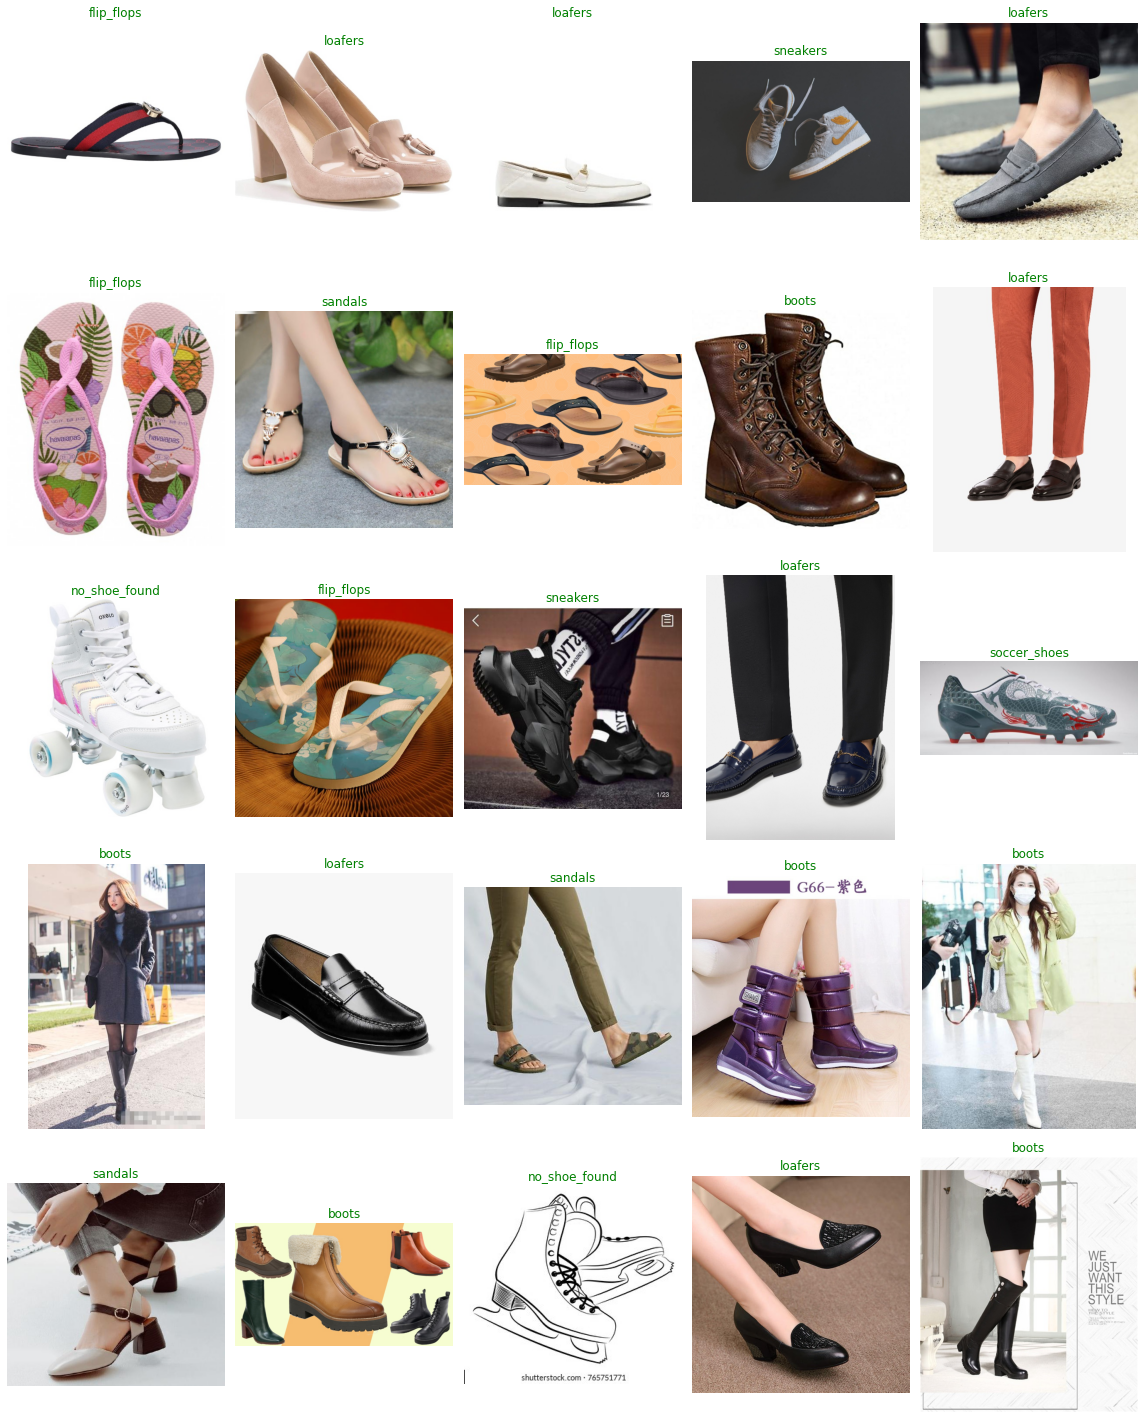

In [6]:
# [Optional] visualization test results

""" data visualization"""
def display_image_grid(image_samples, predicted_labels=(), classes=None, cols=5):
    """ref: https://albumentations.ai/docs/examples/pytorch_classification/"""
    rows = (len(image_samples) - 1) // cols + 1
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 20))
    for i, (image_filepath, true_label) in enumerate(image_samples):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        if classes is not None:
            predicted_label = classes[predicted_label]
                
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

visual_samples = [(test_samples[i][0], results[i]) for i in np.random.choice(len(test_samples), 25, replace=False)]
display_image_grid(visual_samples, classes=CLASSES)